# MS 2.1- Group 10

The following sections describe and implement an attempt to Audio Identification. We experimented with various configurations and parameter settings to achieve a high accuracy in the audio identification of our test queries. 

# Imports

In [1]:
# imports
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
from IPython.display import clear_output


%matplotlib inline

# Utility functions

Here we define all functions that, we later need to compute spectrograms, constellation maps, and perform the matching

This function is responsible for computing the spectrogram map of a given track. We limit the track duration that is used to 30 seconds.

In [2]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None, duration=None):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

This function computes the constellation map, given a spectrogram map

In [3]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

Function to plot the constellation map. Used for inspection purposes, when deciding on parameters for dist_freq and dist_time.

In [4]:
def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    

Helper function that matches two binary matrices.

In [5]:
import numpy as np
from scipy import ndimage
from numba import jit, prange
def match_binary_matrices_tol(C_ref, C_est, C_est_max, tol_freq=0, tol_time=0):
    """Compare binary matrices with tolerance."""
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND

The following two functions compute the match between the query constellation map and the database-track constellation map by sliding the query over the database-track. To optimize the matching process, we refactored the code from the original example notebook into two separate functions: compute_matching_function and compute_matching_function_numba.

The compute_matching_function handles assertions and precomputes the C_est_max filter, which is used to estimate the maximum region for the query. It then calls compute_matching_function_numba, a Numba-optimized function.

Numba compiles the compute_matching_function_numba to machine code and parallelizes the loop using all available CPU cores. This optimization significantly improves runtime, reducing execution time from almost an hour in the naive implementation to just under 5 minutes.

In [6]:
@jit(nopython=True, parallel=True)
def compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq=0, tol_time=0):
    """Numba-accelerated computation of the matching function."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    Delta = np.zeros(M + 1, dtype=np.float64)

    for m in prange(M + 1):  # Parallelized loop
        C_D_crop = C_D[:, m:m + N]
        C_AND = np.logical_and(C_est_max, C_D_crop)
        TP = np.sum(C_AND)
        Delta[m] = TP

    shift_max = np.argmax(Delta)
    return Delta, shift_max

In [7]:
def compute_matching_function(C_D, C_Q, tol_freq=0, tol_time=0):
    """Computes matching function for constellation maps."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"

    # Precompute the max filter for the estimation (outside of Numba)
    C_est_max = ndimage.maximum_filter(C_Q, size=(2 * tol_freq + 1, 2 * tol_time + 1), mode='constant')

    # Use the Numba-accelerated version
    Delta, shift_max = compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq, tol_time)
    return Delta, shift_max

### Load all filenames
This function is used to load all filenames, that are contained in a specified directory. 

In [8]:
def load_filenames(directory):
    filenames = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Create the full path
        file_path = os.path.join(directory, filename)
        
        # Check if it is a file (not a directory)
        if os.path.isfile(file_path):
            # Add to the dictionary, using the filename as the key
            filenames.append(file_path)

    return filenames

### Compute constellation maps for filenames
The following functions compute constellation maps for a given list of track or query filenames. To optimize performance, the computation is multithreaded, significantly reducing the processing time. For each file, the process involves computing the spectrogram and subsequently generating the corresponding constellation map.

In [9]:
from concurrent.futures import ThreadPoolExecutor

def compute_constellation_map_single(args):
    """Compute the constellation map for a single file."""
    filename, dist_freq, dist_time = args
    spectrogram = compute_spectrogram(filename)  # Perform I/O and computation
    constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
    return filename, constellation_map

def compute_constellation_maps(filenames, dist_freq, dist_time):
    """Compute constellation maps using multithreading."""
    # Prepare arguments for each file
    args = [(filename, dist_freq, dist_time) for filename in filenames]
    
    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_constellation_map_single, args)
    
    # Convert results to a dictionary
    Cmaps = dict(results)
    return Cmaps

# Task 2: Database Preparation
In this section we prepare the database. We first create an array holding information for our 4 different configurations. Each configuration is essentially a dictionary holding information on different parameters (κ, τ , tol_, ...) but is also later going to be used for storing the constellation maps of our database tracks, as well as the constellation maps of our queries for our experiments. This dictionary also stores the matches which we calculate later on. 

In [10]:
# each configuration is represented by a dictionary defining the configuration, storing the computed constellation maps, and the matches 

configs = [
    {"kappa": 7, "tau": 3, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 11, "tau": 3, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 10, "tau": 10, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 6, "tau": 17, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}}
]

Now we load all tracks we want to have in our database into memory and compute the constellation maps for each of the 4 specified configurations.

In [11]:
tracks = load_filenames('tracks') # load all track filenames
for config in configs: 
    config["cmaps_D"] = compute_constellation_maps(tracks, config["kappa"], config["tau"]) # store the computed constellation maps for each configuration.

## Visualization of example constellation maps for each configuration
Here we demonstratively show for each chosen configuration, how a constellation map for a track looks like for the given parameters.

### κ = 7, τ = 3

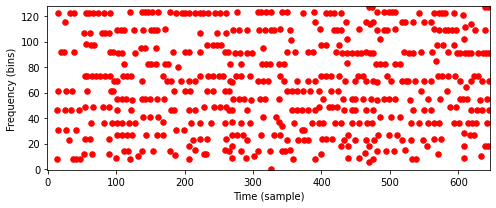

In [12]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

### κ = 11, τ = 3

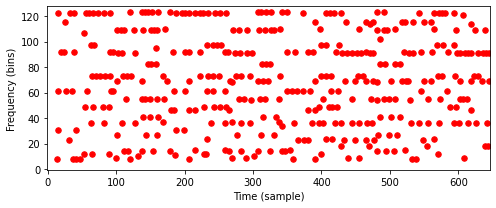

In [13]:
fig, ax, im = plot_constellation_map(configs[1]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

### κ = 10, τ = 10

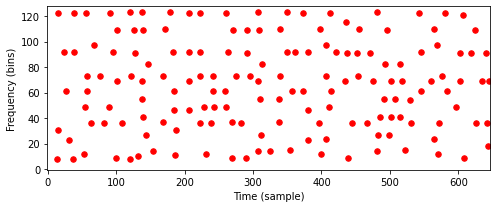

In [14]:
fig, ax, im = plot_constellation_map(configs[2]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

### κ = 6, τ = 17

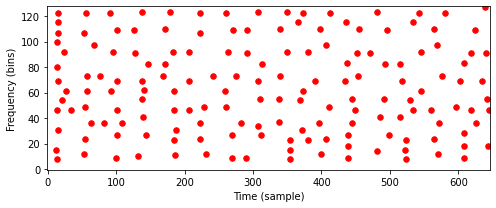

In [15]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

# Task 3: Retrieval Experimentation

In this section, we first create constellation maps for each of the queries, with the exact same parameter combinations, which we used for the database-tracks above.

Here we load all queries, we want to test into memory and compute the constellation maps for each of the 4 specified configurations.

In [16]:
queries = load_filenames('queries')
for config in configs: 
    config["cmaps_Q"] = compute_constellation_maps(queries, config["kappa"], config["tau"])

## Visualization of example constellation maps for each configuration
Here we demonstratively show for each chosen configuration, how a constellation map for a query looks like for the given parameters.

### κ = 7, τ = 3

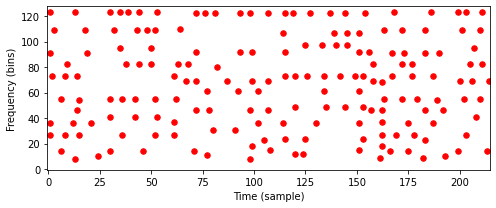

In [17]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

### κ = 11, τ = 3

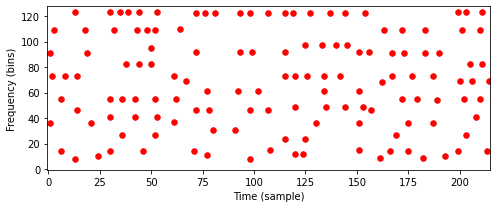

In [18]:
fig, ax, im = plot_constellation_map(configs[1]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

### κ = 10, τ = 10

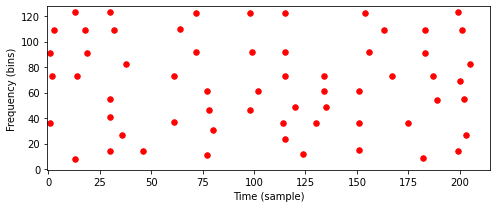

In [19]:
fig, ax, im = plot_constellation_map(configs[2]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

### κ = 6, τ = 17

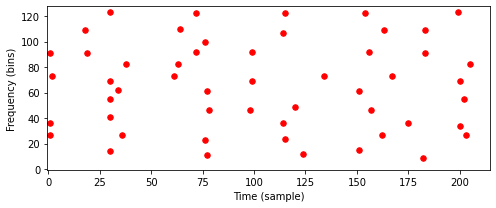

In [20]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

## Matching

After preprocessing our tracks and queries, we can finally start the matching. We do the matching of queries and database-tracks for each of the previously defined parameter combinations. 

For each configuration, we follow a systematic process to identify the best match for each query:

- Iterate Through Queries: For every query, its constellation map is compared against all the database track constellation maps.
- Compute Matching Scores: Using the compute_matching_function, a score is calculated for each query-to-track combination.
- Track the Best Match: The track with the highest matching score for each query is identified as the best match. This is stored in a dictionary along with its corresponding score.
- Evaluate Results: We determine how many queries were correctly matched to their corresponding tracks by comparing the predicted matching track to the query's expected match (based on their filenames).

In [21]:


for config in configs:
    print(f"***** Configuration: κ={config['kappa']}, τ={config['tau']} *****")
    
    config["hits"] = {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}
    
    for name_Q, cmap_Q in config["cmaps_Q"].items():
        best_score = 0
        best_name = None


        start_time = time.time()

        for name_D, cmap_D in config["cmaps_D"].items():
            delta, shift_max = compute_matching_function(cmap_D, cmap_Q, tol_freq=config["tol_freq"], tol_time=config["tol_time"])

            if delta[shift_max] > best_score:
                best_score = delta[shift_max]
                best_name = name_D

    
        end_time = time.time()
        config["matches"][name_Q] = {"matching_track": best_name, "score": best_score, "time": (end_time-start_time)}

        track_num = name_Q.split('/')[1].split('_')[0] 
        if track_num in best_name:
            config["hits"]["total"] += 1

            if "noise" in name_Q:
                config["hits"]["noise"] += 1
            elif "coding" in name_Q:
                config["hits"]["coding"] += 1
            elif "mobile" in name_Q:
                config["hits"]["mobile"] += 1
            else:
                config["hits"]["original"] += 1


    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0

    print(f"Average time per query: {average_time:.2f} seconds")
    print(f"Matched {config['hits']['total']} of {len(queries)} queries correctly.")
    print(f"Original: {config['hits']['original']} / {20}.")
    print(f"Noise: {config['hits']['noise']} / {20}.")
    print(f"Coding: {config['hits']['coding']} / {20}.")
    print(f"Mobile: {config['hits']['mobile']} / {20}.")

    
    
    print("\n\n")
    


***** Configuration: κ=7, τ=3 *****
Average time per query: 2.15 seconds
Matched 73 of 80 queries correctly.
Original: 20 / 20.
Noise: 19 / 20.
Coding: 20 / 20.
Mobile: 14 / 20.



***** Configuration: κ=11, τ=3 *****
Average time per query: 2.02 seconds
Matched 74 of 80 queries correctly.
Original: 20 / 20.
Noise: 19 / 20.
Coding: 20 / 20.
Mobile: 15 / 20.



***** Configuration: κ=10, τ=10 *****
Average time per query: 1.96 seconds
Matched 70 of 80 queries correctly.
Original: 20 / 20.
Noise: 18 / 20.
Coding: 20 / 20.
Mobile: 12 / 20.



***** Configuration: κ=6, τ=17 *****
Average time per query: 1.87 seconds
Matched 73 of 80 queries correctly.
Original: 20 / 20.
Noise: 20 / 20.
Coding: 20 / 20.
Mobile: 13 / 20.





 # Evaluation:
 In this section we compare and visualize our experiments.

# Thought process on the chosen parameters

The parameter κ controls how much of the frequency range we look at when detecting peaks in the spectrogram. A smaller κ focuses on fine details, which can be useful for identifying subtle features, but it also increases sensitivity to noise. On the other hand, a larger κ smooths the frequency data, emphasizing dominant peaks while reducing noise sensitivity. However, this can result in missing some important details.  
We tested different values, such as κ = 7, 10, 11, to find a good balance between capturing meaningful features and ignoring noise.

The parameter τ functions similarly to κ, but in the time domain. A smaller τ captures quick temporal# Thought process on the chosen parameters

The parameter κ controls how much of the frequency range we look at when detecting peaks in the spectrogram. A smaller κ focuses on fine details, which can be useful for identifying subtle features, but it also increases sensitivity to noise. On the other hand, a larger κ smooths the frequency data, emphasizing dominant peaks while reducing noise sensitivity. However, this can result in missing some important details.  
We tested different values, such as κ = 7, 10, 11, to find a good balance between capturing meaningful features and ignoring noise.

The parameter τ functions similarly to κ, but in the time domain. A smaller τ captures quick temporal changes, which is beneficial for identifying short, sharp features, but it can also make the system more sensitive to noise. Conversely, a larger τ smooths out the time axis, making it more robust to distortions like jitter or background noise, though it might miss rapid changes.  
We experimented with τ = 3, 10, 15 to achieve a balance between temporal precision and robustness to noise.

Tol_freq determines how much frequency mismatch is acceptable when comparing the query and track constellation maps. A smaller tol_freq enforces stricter matching, which works well for clean audio but struggles with small distortions or artifacts. A larger tol_freq allows for some flexibility, making the system more robust to real-world imperfections like compression or slight frequency shifts.  
For most configurations, we used tol_freq = 0 for clean data and increased it to 1 when testing on noisier or distorted audio.

Tol_time controls the acceptable timing mismatch during matching. A smaller tol_time ensures precise alignment between the query and track but is less forgiving to tempo variations or timing distortions. A larger tol_time allows for better handling of these issues but can increase the risk of false positives.  
We used tol_time= 0 for strict alignment and tol_time = 1 for scenarios involving timing variations.

Through experimentation, we found configurations that balance accuracy and robustness. However finding suitable parameters for mobile was challenging due to the significant differences between the recordings and the original. changes, which is beneficial for identifying short, sharp features, but it can also make the system more sensitive to noise. Conversely, a larger τ smooths out the time axis, making it more robust to distortions like jitter or background noise, though it might miss rapid changes.  
We experimented with τ = 3, 10, 15 to achieve a balance between temporal precision and robustness to noise.

Tol_freq determines how much frequency mismatch is acceptable when comparing the query and track constellation maps. A smaller tol_freq enforces stricter matching, which works well for clean audio but struggles with small distortions or artifacts. A larger tol_freq allows for some flexibility, making the system more robust to real-world imperfections like compression or slight frequency shifts.  
For most configurations, we used tol_freq = 0 for clean data and increased it to 1 when testing on noisier or distorted audio.

Tol_time controls the acceptable timing mismatch during matching. A smaller tol_time ensures precise alignment between the query and track but is less forgiving to tempo variations or timing distortions. A larger tol_time allows for better handling of these issues but can increase the risk of false positives.  
We used tol_time= 0 for strict alignment and tol_time = 1 for scenarios involving timing variations.

Through experimentation, we found configurations that balance accuracy and robustness. However finding suitable parameters for mobile was challenging due to the significant differences between the recordings and the original.

## Table

In [38]:
import pandas as pd




# Example data
average_times = []
for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    average_times.append(average_time)

max_times = [max(entry["time"] for entry in config["matches"].values()) for config in configs]
min_times = [min(entry["time"] for entry in config["matches"].values()) for config in configs]



data = {
    "Average Query Time (sec)": average_times,
    "Max Query Time (sec)": max_times,
    "Min Query Time (sec)": min_times,
    "Total Accuracy (%)": [config["hits"]["total"]/len(queries) for config in configs],
    "Original Accuracy (%)": [(config["hits"]["original"]/20)*100 for config in configs],
    "Noise Accuracy (%)": [(config["hits"]["noise"]/20)*100 for config in configs],
    "Coding Accuracy (%)": [(config["hits"]["coding"]/20)*100 for config in configs],
    "Mobile Accuracy (%)": [(config["hits"]["mobile"]/20)*100 for config in configs],
}

# Row labels
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]

# Create the DataFrame
df = pd.DataFrame(data, index=labels)
df

,Average Query Time (sec),Max Query Time (sec),Min Query Time (sec),Total Accuracy (%),Original Accuracy (%),Noise Accuracy (%),Coding Accuracy (%),Mobile Accuracy (%)
"kappa=7, tau=3",2.147065,5.229421,1.148820,0.9125,100.0,95.0,100.0,70.0
"kappa=11, tau=3",2.023021,3.405236,1.148515,0.9250,100.0,95.0,100.0,75.0
"kappa=10, tau=10",1.964539,2.902942,1.085817,0.8750,100.0,90.0,100.0,60.0
"kappa=6, tau=17",1.867338,2.893833,1.107419,0.9125,100.0,100.0,100.0,65.0


## Query time comparison

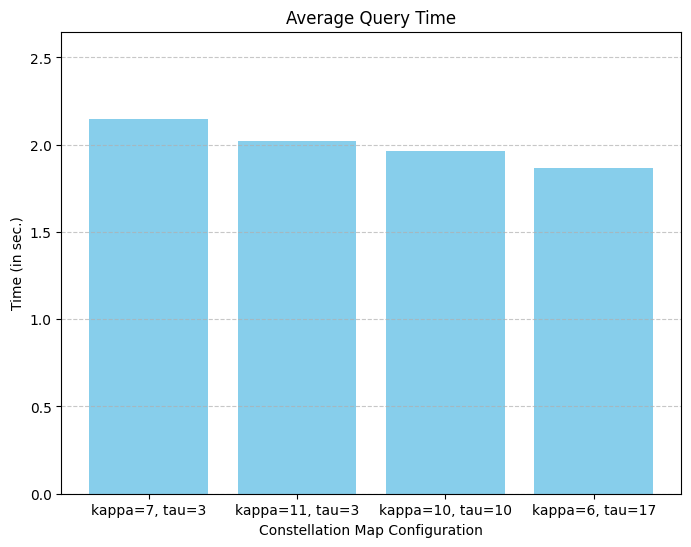

In [22]:
import matplotlib.pyplot as plt

# Values to plot
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
values = [] 

for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    values.append(average_time)

# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.title('Average Query Time')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Time (in sec.)')
plt.ylim(0, max(values) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

## Matching Accuracy Comparison

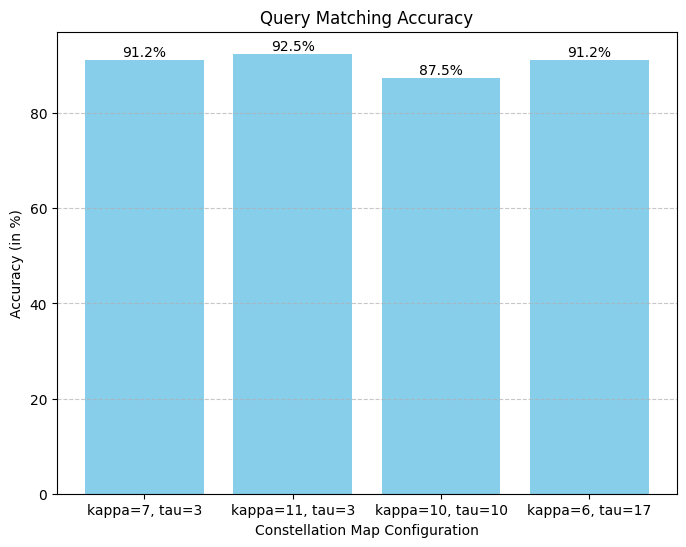

In [23]:
import matplotlib.pyplot as plt


# Values to plot
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
values = [config["hits"]["total"]/len(queries)*100 for config in configs]


# Creating the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color='skyblue')

# Adding percentages above the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Adding title and labels
plt.title('Query Matching Accuracy')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Accuracy (in %)')
#plt.ylim(80, 100)  # Leave some space above the bars for annotations
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


## Category Comparison

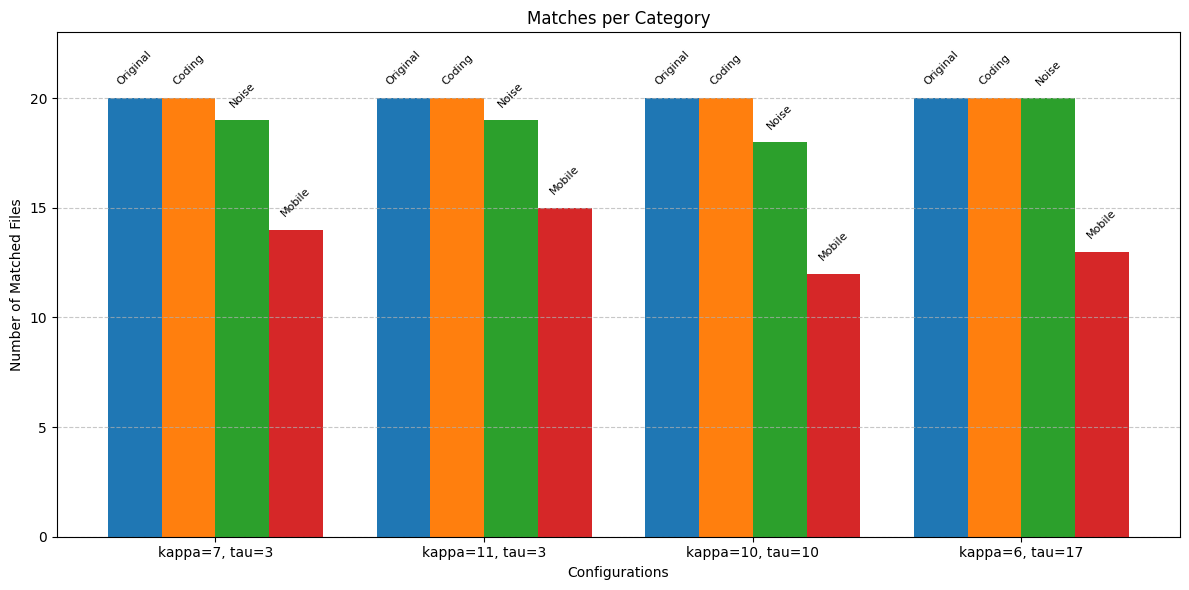

In [27]:
# Configuration names and corresponding counts for each category
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
matched_original = [config["hits"]["original"] for config in configs]
matched_coding = [config["hits"]["coding"] for config in configs]
matched_noise = [config["hits"]["noise"] for config in configs]
matched_mobile = [config["hits"]["mobile"] for config in configs]

# Number of configurations
num_configs = len(labels)

# X positions for groups of bars
x = np.arange(num_configs)

# Width of each bar
bar_width = 0.2

# Categories and their data
categories = ['Original', 'Coding', 'Noise', 'Mobile']
data = [matched_original, matched_coding, matched_noise, matched_mobile]

# Plot
plt.figure(figsize=(12, 6))

for i, category_data in enumerate(data):
    # Offset for each bar in a group
    bar_positions = x + (i - 1.5) * bar_width
    bars = plt.bar(bar_positions, category_data, width=bar_width)
    
    # Add category labels on top of each bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Adjusted offset for more space
                 categories[i], ha='center', va='bottom', rotation=45, fontsize=8)

# Add labels, title, and legend
plt.xlabel('Configurations')
plt.ylabel('Number of Matched Files')
plt.title('Matches per Category')
plt.xticks(x, labels)

# Adjust the y-axis to leave more space at the top
plt.ylim(0, max(max(matched_original), max(matched_coding), max(matched_noise), max(matched_mobile)) + 3)

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()